# Setup Notebook

In [1]:
# When working in AI LRZ
%cd ~/cma/CMA_Fairness_v2

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2


/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%run analysis__setup.ipynb

/dss/dsshome1/0C/ra93lal2/cma/CMA_Fairness_v2
The data has N = 128 rows and N = 56 columns.
Dropping N = 64 rows, keeping N = 64


## Prepare Data


In [3]:
# Filter out a single configuration to keep data manageable
df_agg = df_agg_full[
  (df_agg_full["sett_eval_fairness_grouping"] == "nationality-all") #&
  #(df_agg_full["sett_eval_exclude_subgroups"] == "keep-in-eval") &
  #(df_agg_full["sett_eval_on_subset"] == "full")
][
  # Remove eval columns
  cols_non_eval + cols_performance + cols_fairness
].reset_index(drop = True)

df_agg.shape

(32, 48)

# Calculate Variable Importance

## Use a Lasso Regression to estimate Importance of Settings

In [4]:
X = df_agg[cols_non_eval]
y = df_agg[main_fairness_metric]

### Main Effects of Settings Only (i.e. no interations)

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV

# Do preprocessing in a separate pipeline from model fitting
# (for eli5 to work)
preprocessor = make_pipeline(
    OneHotEncoder(), # Converts categorical features to one-hot encoded format
).fit(X) # Fit the preprocessing pipeline to the input data X
X_processed = preprocessor.transform(X) # This creates a numeric matrix suitable for modeling

# Fit a Lasso regression model with cross-validation to the processed data
lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.7927119947702317

R² = 1.0: Perfect predictions

R² = 0.0: Model does no better than predicting the mean

R² < 0.0: Model is worse than just predicting the mean

Weights of importance:

In [6]:
# Visualize the importance of each feature in trained lasso_reg model
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.136,<BIAS>
+0.056,sett_model_elasticnet
+0.050,sett_model_logreg
+0.000,sett_cutoff_quantile_0.25
-0.015,sett_model_gbm
-0.028,sett_model_rf
-0.068,sett_cutoff_quantile_0.1


### Including Interactions

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LassoCV

# Do preprocessing w/o a pipeline for eli5 to work
preprocessor = make_pipeline(
    OneHotEncoder(),
    PolynomialFeatures(degree=2),
).fit(X)
X_processed = preprocessor.transform(X)

lasso_reg = LassoCV(cv=5, random_state=0).fit(X_processed, y)

# Check whether it's predictive at all
lasso_reg.score(X_processed, y) # Evaluate the model's R^2 score on the training data


0.9961470303459696

Weights of importance:

In [8]:
import eli5
eli5.show_weights(lasso_reg, top=-1, feature_names = preprocessor.get_feature_names_out())


Weight?,Feature
+0.113,<BIAS>
+0.102,sett_cutoff_quantile_0.25 sett_model_elasticnet
+0.085,sett_cutoff_quantile_0.25 sett_model_logreg
+0.015,sett_model_logreg
+0.014,sett_model_elasticnet
+0.001,sett_model_logreg^2
+0.000,sett_model_rf sett_exclude_features_nationality-sex
+0.000,sett_cutoff_quantile_0.1 sett_exclude_features_nationality-sex
+0.000,sett_cutoff_quantile_0.25^2
+0.000,sett_cutoff_quantile_0.25


## Use a functinoal ANOVA (fANOVA) to Analyze Setting Importance

Based on the following paper:

Hutter, F., Hoos, H., & Leyton-Brown, K. (2014). An Efficient Approach for Assessing Hyperparameter Importance. Proceedings of the 31st International Conference on Machine Learning, 754–762. https://proceedings.mlr.press/v32/hutter14.html


In [9]:
from fairness_multiverse.analysis import MultiverseFanova

m_fanova = MultiverseFanova(features = df_agg[cols_non_eval], outcome = df_agg[main_fairness_metric])


In [10]:
# delete later
df_agg_cols_non_eval = df_agg[cols_non_eval].copy()
df_agg_main_fairness_metric = df_agg[main_fairness_metric].copy()

In [11]:
# delete later
import fanova
print(fanova.__file__)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/__init__.py


In [12]:
m_fanova.quantify_individual_importance()

,individual importance,total importance,individual std,total std
sett_cutoff,0.323063,0.323063,0.208592,0.208592
sett_exclude_features,0.020632,0.020632,0.039158,0.039158
sett_exclude_subgroups,0.000000,0.000000,0.000000,0.000000
sett_model,0.415461,0.415461,0.189525,0.189525


In [13]:
m_fanova.quantify_importance(save_to = ANALYSIS_OUTPUT_DIR / "fanova_importance_interactions-overall.csv")

,level_0,level_1,level_2,level_3,individual importance,total importance,individual std,total std
3,sett_model,NaN,NaN,NaN,0.415461,0.415461,0.189525,1.895251e-01
0,sett_cutoff,NaN,NaN,NaN,0.323063,0.323063,0.208592,2.085919e-01
6,sett_cutoff,sett_model,NaN,NaN,0.144208,0.882733,0.079785,1.538747e-01
8,sett_exclude_features,sett_model,NaN,NaN,0.055665,0.491758,0.092844,1.913173e-01
4,sett_cutoff,sett_exclude_features,NaN,NaN,0.024099,0.367794,0.043372,2.263538e-01
1,sett_exclude_features,NaN,NaN,NaN,0.020632,0.020632,0.039158,3.915761e-02
11,sett_cutoff,sett_exclude_features,sett_model,NaN,0.016872,1.000000,0.028685,2.884444e-16
2,sett_exclude_subgroups,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000e+00
5,sett_cutoff,sett_exclude_subgroups,NaN,NaN,0.000000,0.323063,0.000000,2.085919e-01
7,sett_exclude_features,sett_exclude_subgroups,NaN,NaN,0.000000,0.020632,0.000000,3.915761e-02


In [14]:
best_p_margs = m_fanova.fanova.get_most_important_pairwise_marginals(n=5)
print(best_p_margs)

OrderedDict([(('sett_cutoff', 'sett_model'), 0.1442080746046065), (('sett_exclude_features', 'sett_model'), 0.05566482107222509), (('sett_cutoff', 'sett_exclude_features'), 0.024099070788671687), (('sett_exclude_subgroups', 'sett_model'), 0.0), (('sett_exclude_features', 'sett_exclude_subgroups'), 0.0)])


In [15]:
from fanova import visualizer

vis = visualizer.Visualizer(m_fanova.fanova, m_fanova.configuration_space, directory = str(ANALYSIS_OUTPUT_DIR))

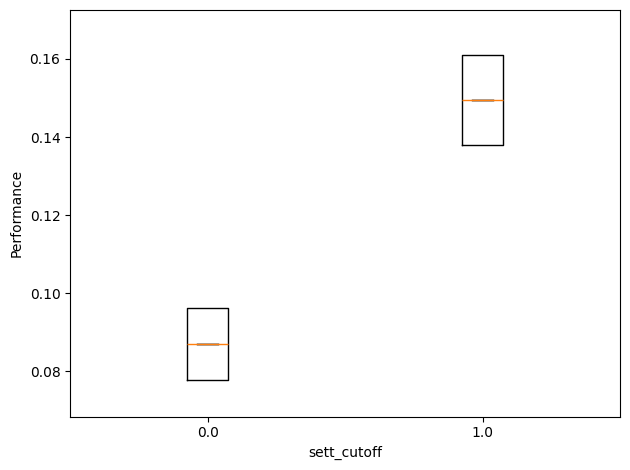

In [16]:
vis.plot_marginal(0)

/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/fanova/visualizer.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  grid_fanova = np.array(grid_fanova)
INFO:fanova.visualizer.Visualizer:creating output/analyses/8/interactive_plots


<module 'matplotlib.pyplot' from '/dss/dsshome1/0C/ra93lal2/.local/share/virtualenvs/CMA_Fairness_v2-3j10GkSs/lib/python3.10/site-packages/matplotlib/pyplot.py'>

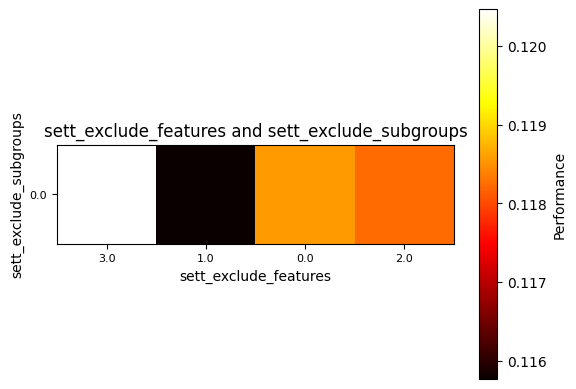

In [17]:
vis.plot_pairwise_marginal(['sett_exclude_features', 'sett_exclude_subgroups'])

## Quantify Importance with Partial Data

In [18]:
from tqdm import tqdm

PARTIAL_FANOVA_DIR = ANALYSIS_OUTPUT_DIR / "partial_fanova" / "overall"
PARTIAL_FANOVA_DIR.mkdir(parents=True, exist_ok=True)

N_ITERATIONS = 10

In [19]:
from fairness_multiverse.analysis import MultiverseFanova
import joblib

def quantify_importance_for_fraction(fraction: float, base_directory = PARTIAL_FANOVA_DIR):
    # Get random subset of the data
    df = df_agg.sample(frac = fraction).reset_index(drop = True)
    data_hash = joblib.hash(df)

    # Create directory for this fraction
    directory = base_directory / f"fraction-{fraction}"
    directory.mkdir(exist_ok = True)

    # Run FANOVA on subset
    partial_fanova = MultiverseFanova(features = df[cols_non_eval], outcome = df[main_fairness_metric])
    partial_fanova.quantify_importance(save_to = directory / f"partial-fanova_importance_interactions-majmin-{fraction}-{data_hash}.csv")

In [20]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.01)

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [21]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.05)

 70%|███████   | 7/10 [00:00<00:00, 29.48it/s]


RuntimeError: Encountered zero total variance in all trees.

In [22]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.1)

100%|██████████| 10/10 [00:00<00:00, 28.77it/s]


In [23]:
for i in tqdm(range(N_ITERATIONS)):
    quantify_importance_for_fraction(0.2)

100%|██████████| 10/10 [00:00<00:00, 22.56it/s]
